<a href="https://colab.research.google.com/github/NajmiAqil/TugasAkhir/blob/main/percobaanTA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.56G/2.56G [00:43<00:00, 63.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/divg07/casia-20-image-tampering-detection-dataset/versions/1


In [3]:
import os

base_dir = os.path.join(path, "CASIA2")
print("Isi subfolder CASIA2:")
print(os.listdir(base_dir))


Isi subfolder CASIA2:
['Tp', 'CASIA 2 Groundtruth', 'Au']


In [4]:
folders = ["Au", "Tp", "CASIA 2 Groundtruth"]
for folder in folders:
    full_path = os.path.join(base_dir, folder)
    print(f"{folder}: {len(os.listdir(full_path))} file")


Au: 7492 file
Tp: 5125 file
CASIA 2 Groundtruth: 5123 file


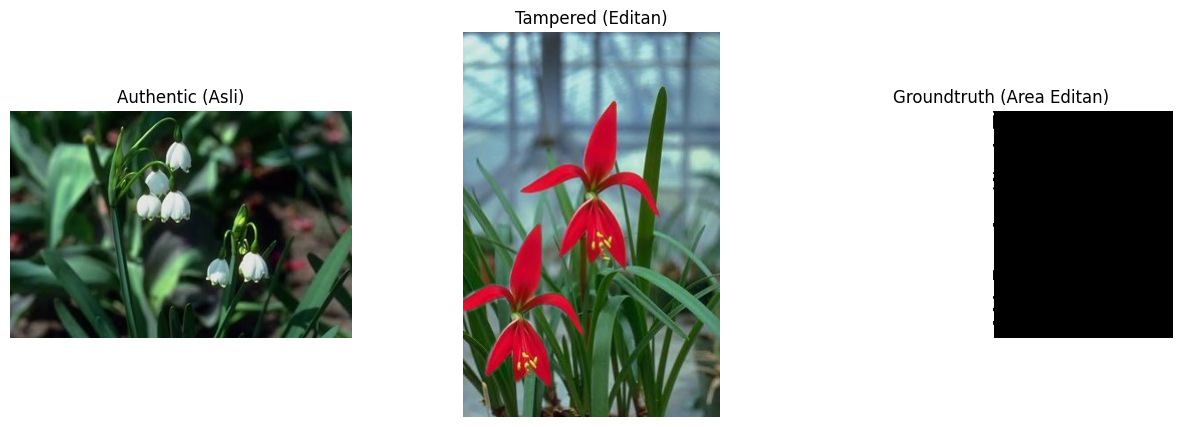

In [5]:
import cv2
import random
from matplotlib import pyplot as plt

# ambil file random dari tiap folder
sample_auth = random.choice(os.listdir(os.path.join(base_dir, "Au")))
sample_tamp = random.choice(os.listdir(os.path.join(base_dir, "Tp")))
sample_mask = random.choice(os.listdir(os.path.join(base_dir, "CASIA 2 Groundtruth")))

# load gambar
img_auth = cv2.imread(os.path.join(base_dir, "Au", sample_auth))
img_tamp = cv2.imread(os.path.join(base_dir, "Tp", sample_tamp))
img_mask = cv2.imread(os.path.join(base_dir, "CASIA 2 Groundtruth", sample_mask), cv2.IMREAD_GRAYSCALE)

# ubah warna BGR ke RGB untuk matplotlib
img_auth = cv2.cvtColor(img_auth, cv2.COLOR_BGR2RGB)
img_tamp = cv2.cvtColor(img_tamp, cv2.COLOR_BGR2RGB)

# tampilkan
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_auth)
plt.title("Authentic (Asli)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_tamp)
plt.title("Tampered (Editan)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_mask, cmap='gray')
plt.title("Groundtruth (Area Editan)")
plt.axis('off')

plt.show()


In [6]:
import cv2
sizes = []
folder_path = os.path.join(base_dir, "Au")
for f in random.sample(os.listdir(folder_path), 50):  # ambil 50 sample acak
    img = cv2.imread(os.path.join(folder_path, f))
    if img is not None:
        sizes.append(img.shape[:2])  # (height, width)

sizes_df = pd.DataFrame(sizes, columns=['height', 'width'])
print(sizes_df.describe())


           height       width
count   50.000000   50.000000
mean   328.760000  360.880000
std     75.026406  114.887103
min    256.000000  256.000000
25%    256.000000  256.000000
50%    379.500000  384.000000
75%    384.000000  384.000000
max    600.000000  800.000000


In [7]:
# Melihat jenis ekstensi file di folder Tp
tp_folder = os.path.join(base_dir, "Tp")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder Tp:")
print(ext_count)


Jenis ekstensi file di folder Tp:
.tif    3059
.jpg    2064
.db        1
.txt       1
Name: count, dtype: int64


In [8]:
# Melihat jenis ekstensi file di folder Au
tp_folder = os.path.join(base_dir, "Au")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder Au:")
print(ext_count)


Jenis ekstensi file di folder Au:
.jpg    7437
.bmp      54
.db        1
Name: count, dtype: int64


In [9]:
# Melihat jenis ekstensi file di folder CASIA 2 Groundtruth
tp_folder = os.path.join(base_dir, "CASIA 2 Groundtruth")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder CASIA 2 Groundtruth:")
print(ext_count)


Jenis ekstensi file di folder CASIA 2 Groundtruth:
.png    5123
Name: count, dtype: int64


In [10]:
import sys
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import shutil
import math

# ---------- CONFIG ----------
# Jika base_dir sudah ada di namespace (dari cell sebelumnya), gunakan; kalau tidak, pakai fallback common Kaggle path
if 'base_dir' in globals():
    BASE_DIR = Path(base_dir)
else:
    BASE_DIR = Path("/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2")

FOLDERS = ["Au", "Tp", "CASIA 2 Groundtruth"]
VALID_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
MOVE_INVALID = False   # ubah ke True jika ingin memindahkan file invalid ke folder invalid_files
INVALID_ROOT = BASE_DIR / "invalid_files"  # jika MOVE_INVALID True, file akan dipindahkan ke sini
MANIFEST_CSV = "casia_manifest.csv"  # nama file manifest yang dibuat di working dir
MAX_SCAN_PER_FOLDER = None  # Diubah dari 200 ke None untuk scan semua file

# ---------- helper ----------
def file_size_bytes(p: Path) -> int:
    try:
        return p.stat().st_size
    except Exception:
        return -1

def try_open_image(p: Path):
    """Return (ok, width, height). ok=False jika gagal buka atau bukan image."""
    try:
        with Image.open(p) as img:
            img.verify()
        with Image.open(p) as img:
            w, h = img.size
        return True, w, h
    except (UnidentifiedImageError, OSError, ValueError):
        return False, None, None

# ---------- scan ----------
rows = []
for folder in FOLDERS:
    folder_path = BASE_DIR / folder
    if not folder_path.exists():
        print(f"[WARN] Folder not found: {folder_path}")
        continue
    count = 0
    for entry in os.scandir(folder_path):
        if not entry.is_file():
            continue
        p = Path(entry.path)
        ext = p.suffix.lower()
        is_ext_image = ext in VALID_EXT
        fsize = file_size_bytes(p)
        can_open, width, height = (False, None, None)
        if is_ext_image:
            can_open, width, height = try_open_image(p)
        rows.append({
            "folder": folder,
            "filename": p.name,
            "filepath": str(p),
            "ext": ext,
            "is_ext_image": is_ext_image,
            "can_open": can_open,
            "width": width,
            "height": height,
            "filesize_bytes": fsize
        })
        count += 1
        if (MAX_SCAN_PER_FOLDER is not None) and count >= MAX_SCAN_PER_FOLDER:
            break

# ---------- manifest ----------
df = pd.DataFrame(rows)
# summary counts
print("Summary ekstensi (overall):")
print(df['ext'].value_counts())
print("\nJumlah file total per folder (sebelum cleaning):")
print(df['folder'].value_counts())

# identify invalid files:
# invalid = not image-ext OR image-ext but cannot open
df['valid'] = df['is_ext_image'] & df['can_open']

print("\nCounts by valid flag:")
print(df['valid'].value_counts(dropna=False))

# show a sample of invalid
invalid_df = df[~df['valid']].copy()
print(f"\nContoh file invalid (max 20): {len(invalid_df)} found")
display(invalid_df.head(20))

# save manifest csv
df.to_csv(MANIFEST_CSV, index=False)
print(f"\nManifest saved to: {MANIFEST_CSV} (rows: {len(df)})")

# ---------- optional: move invalid files ----------
if MOVE_INVALID and len(invalid_df)>0:
    print("\nMemindahkan file invalid ke folder:", INVALID_ROOT)
    for _, r in invalid_df.iterrows():
        src = Path(r['filepath'])
        dest_dir = INVALID_ROOT / r['folder']
        dest_dir.mkdir(parents=True, exist_ok=True)
        dest = dest_dir / src.name
        try:
            shutil.move(str(src), str(dest))
        except Exception as e:
            print("Failed to move", src, "->", dest, ":", e)
    print("Pemindahan selesai. (Periksa folder invalid_files)")

# ---------- counts after cleaning (if we were to only consider valid) ----------
valid_counts = df[df['valid']==True].groupby('folder').size().rename('valid_count')
total_counts = df.groupby('folder').size().rename('total_count')
summary = pd.concat([total_counts, valid_counts], axis=1).fillna(0).astype(int)
summary['invalid_count'] = summary['total_count'] - summary['valid_count']
print("\nRingkasan sebelum/sesudah (per folder):")
display(summary)

# ---------- optional: save lists of valid files per folder ----------
for folder in FOLDERS:
    out_csv = f"valid_files_{folder.replace(' ','_')}.csv"
    df_valid = df[(df['folder']==folder) & (df['valid']==True)].copy()
    df_valid.to_csv(out_csv, index=False)
    print(f"Saved {len(df_valid)} valid file entries for '{folder}' to {out_csv}")

print("\nSelesai. Lihat casia_manifest.csv dan valid_files_*.csv untuk daftar file yang valid.")


Summary ekstensi (overall):
ext
.jpg    9501
.png    5123
.tif    3059
.bmp      54
.db        2
.txt       1
Name: count, dtype: int64

Jumlah file total per folder (sebelum cleaning):
folder
Au                     7492
Tp                     5125
CASIA 2 Groundtruth    5123
Name: count, dtype: int64

Counts by valid flag:
valid
True     17737
False        3
Name: count, dtype: int64

Contoh file invalid (max 20): 3 found


,folder,filename,filepath,ext,is_ext_image,can_open,width,height,filesize_bytes,valid
2515,Au,Thumbs.db,/root/.cache/kagglehub/datasets/divg07/casia-2...,.db,False,False,NaN,NaN,77312,False
9182,Tp,Thumbs.db,/root/.cache/kagglehub/datasets/divg07/casia-2...,.db,False,False,NaN,NaN,32768,False
10409,Tp,_list.txt,/root/.cache/kagglehub/datasets/divg07/casia-2...,.txt,False,False,NaN,NaN,215175,False



Manifest saved to: casia_manifest.csv (rows: 17740)

Ringkasan sebelum/sesudah (per folder):


,total_count,valid_count,invalid_count
folder,,,
Au,7492,7491,1
CASIA 2 Groundtruth,5123,5123,0
Tp,5125,5123,2


Saved 7491 valid file entries for 'Au' to valid_files_Au.csv
Saved 5123 valid file entries for 'Tp' to valid_files_Tp.csv
Saved 5123 valid file entries for 'CASIA 2 Groundtruth' to valid_files_CASIA_2_Groundtruth.csv

Selesai. Lihat casia_manifest.csv dan valid_files_*.csv untuk daftar file yang valid.


In [11]:
# Cell: split_dataset.ipynb
from sklearn.model_selection import train_test_split

random.seed(42)

BASE_DIR = Path(base_dir)  # pakai base_dir yang sudah kamu miliki
OUT_DIR = Path("casia_split")  # hasil split akan disimpan di sini
OUT_DIR.mkdir(exist_ok=True)

# load valid file lists (yang tadi disimpan)
df_au = pd.read_csv("valid_files_Au.csv")
df_tp = pd.read_csv("valid_files_Tp.csv")

# buat label kolom
df_au['label'] = 'authentic'
df_tp['label'] = 'tampered'
df_all = pd.concat([df_au, df_tp], ignore_index=True)

# kita gunakan filename saja (kolom 'filename' dan folder)
# split stratified berdasarkan label
train_val, test = train_test_split(df_all, test_size=0.15, stratify=df_all['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.1764706, stratify=train_val['label'], random_state=42)
# 0.1764706 * 85% ≈ 15% (so overall 70/15/15)

print("Counts:", "train", len(train), "val", len(val), "test", len(test))
for split_name, df_split in [('train', train), ('val', val), ('test', test)]:
    for lbl in ['authentic', 'tampered']:
        c = (df_split['label']==lbl).sum()
        print(f"{split_name} {lbl}: {c}")

# create folders and copy files (or you can create symlink)
for split_name, df_split in [('train', train), ('val', val), ('test', test)]:
    for lbl in ['authentic','tampered']:
        target_dir = OUT_DIR / split_name / lbl
        target_dir.mkdir(parents=True, exist_ok=True)
    for _, row in df_split.iterrows():
        src = Path(row['filepath'])  # path lengkap
        dst = OUT_DIR / split_name / row['label'] / src.name
        if not dst.exists():
            shutil.copy(src, dst)  # atau shutil.copy2 to retain metadata

print("Split and copy done. Inspect casia_split/ folder.")


Counts: train 8829 val 1892 test 1893
train authentic: 5243
train tampered: 3586
val authentic: 1124
val tampered: 768
test authentic: 1124
test tampered: 769
Split and copy done. Inspect casia_split/ folder.


In [12]:
from tqdm.notebook import tqdm

IN_TEST_DIR = Path("casia_split/test")
OUT_DEG_DIR = Path("casia_split/test_degraded")
OUT_DEG_DIR.mkdir(exist_ok=True)

# parameters (reduced for faster runtime, slightly expanded)
TARGET_SIZE = (224,224)
JPEG_QUALITIES = [90, 70]
GAUSSIAN_NOISE_SIGMA = [5, 15]
GAUSSIAN_BLUR_K = [3,5]
DOWNSCALE_FACTORS = [0.5]
MAX_DEGRADE_FILES = 250

def preprocess_and_save(img, outpath):
    img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    cv2.imwrite(str(outpath), img_resized)

def add_gaussian_noise(img, sigma):
    img_f = img.astype(np.float32)
    noise = np.random.normal(0, sigma, img_f.shape).astype(np.float32)
    out = img_f + noise
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

def add_gaussian_blur(img, k):
    return cv2.GaussianBlur(img, (k,k), 0)

def jpeg_compress(img, quality):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    is_success, encimg = cv2.imencode('.jpg', img, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg

def down_upscale(img, factor):
    h,w = img.shape[:2]
    new_h, new_w = max(1,int(h*factor)), max(1,int(w*factor))
    small = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    up = cv2.resize(small, (w,h), interpolation=cv2.INTER_LINEAR)
    return up

def occlude_random_block(img, block_frac=0.2):
    h,w = img.shape[:2]
    bh = int(h*block_frac); bw = int(w*block_frac)
    x = np.random.randint(0,w-bw+1)
    y = np.random.randint(0,h-bh+1)
    img2 = img.copy()
    img2[y:y+bh, x:x+bw] = 0
    return img2

# iterate test set, create degraded versions
for label in ['authentic','tampered']:
    src_dir = IN_TEST_DIR / label
    files = list(src_dir.glob('*'))[:MAX_DEGRADE_FILES]
    for p in tqdm(files, desc=f"processing {label}"):
        img = cv2.imread(str(p))
        if img is None:
            continue
        # baseline preprocessed save
        base_out = OUT_DEG_DIR / 'clean' / label
        base_out.mkdir(parents=True, exist_ok=True)
        preprocess_and_save(img, base_out / p.name)

        # JPEG qualities
        for q in JPEG_QUALITIES:
            outdir = OUT_DEG_DIR / f'jpeg_q{q}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_j = cv2.resize(img, TARGET_SIZE)
            img_j = jpeg_compress(img_j, q)
            cv2.imwrite(str(outdir / p.name), img_j)

        # Gaussian noise
        for s in GAUSSIAN_NOISE_SIGMA:
            outdir = OUT_DEG_DIR / f'gn_sigma{s}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_n = add_gaussian_noise(cv2.resize(img, TARGET_SIZE), s)
            cv2.imwrite(str(outdir / p.name), img_n)

        # Gaussian blur
        for k in GAUSSIAN_BLUR_K:
            outdir = OUT_DEG_DIR / f'gb_k{k}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_b = add_gaussian_blur(cv2.resize(img, TARGET_SIZE), k)
            cv2.imwrite(str(outdir / p.name), img_b)

        # downscale
        for fct in DOWNSCALE_FACTORS:
            outdir = OUT_DEG_DIR / f'down_{int(fct*100)}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_d = down_upscale(img, fct)
            cv2.imwrite(str(outdir / p.name), cv2.resize(img_d, TARGET_SIZE))

        # occlusion
        outdir = OUT_DEG_DIR / 'occlusion' / label
        outdir.mkdir(parents=True, exist_ok=True)
        img_oc = occlude_random_block(cv2.resize(img, TARGET_SIZE), block_frac=0.25)
        cv2.imwrite(str(outdir / p.name), img_oc)

print("Pembuatan degraded test set selesai (lihat casia_split/test_degraded/)")

processing authentic:   0%|          | 0/250 [00:00<?, ?it/s]

processing tampered:   0%|          | 0/250 [00:00<?, ?it/s]

Pembuatan degraded test set selesai (lihat casia_split/test_degraded/)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 128  # ✅ Dikembalikan ke 128x128 seperti percobaanTA2Lama untuk JPEG robustness
BATCH_SIZE = 32
Z_DIM = 100
EPOCHS = 25  # ✅ 25 epochs optimal seperti percobaanTA2Lama
SAVE_DIR = Path("gan_lightweight")  # Sesuaikan dengan nama versi lama
SAVE_DIR.mkdir(exist_ok=True)

print("Device:", DEVICE)
print(f"IMG_SIZE: {IMG_SIZE}x{IMG_SIZE}")
print(f"Total Epochs: {EPOCHS}")


Device: cpu
IMG_SIZE: 128x128
Total Epochs: 25


In [15]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_data = datasets.ImageFolder(root="casia_split/train", transform=transform)

print(f"Using all available images for training")
print(f"Classes: {train_data.classes}")
print(f"Total images: {len(train_data)}")

# Hitung jumlah gambar per kelas
import numpy as np
targets = np.array(train_data.targets)
for class_idx in range(len(train_data.classes)):
    count = (targets == class_idx).sum()
    print(f"  {train_data.classes[class_idx]}: {count} images")

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)


Using all available images for training
Classes: ['authentic', 'tampered']
Total images: 8829
  authentic: 5243 images
  tampered: 3586 images


In [16]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=32):  # ✅ features=32 seperti percobaanTA2Lama
        super().__init__()
        # Untuk output 128x128 (sesuai percobaanTA2Lama)
        self.net = nn.Sequential(
            # 1x1 -> 4x4
            nn.ConvTranspose2d(z_dim, features_g*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(True),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(features_g*8, features_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(True),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(features_g*4, features_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(True),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(features_g*2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),
            # 32x32 -> 64x64
            nn.ConvTranspose2d(features_g, features_g//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g//2),
            nn.ReLU(True),
            # 64x64 -> 128x128
            nn.ConvTranspose2d(features_g//2, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


In [17]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=32):  # ✅ features=32 seperti percobaanTA2Lama
        super().__init__()
        # Untuk input 128x128 (sesuai percobaanTA2Lama)
        self.net = nn.Sequential(
            # 128x128 -> 64x64
            nn.Conv2d(img_channels, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # 64x64 -> 32x32
            nn.Conv2d(features_d, features_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2),
            # 32x32 -> 16x16
            nn.Conv2d(features_d*2, features_d*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2),
            # 16x16 -> 8x8
            nn.Conv2d(features_d*4, features_d*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*8),
            nn.LeakyReLU(0.2),
            # 8x8 -> 4x4
            nn.Conv2d(features_d*8, features_d*16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*16),
            nn.LeakyReLU(0.2),
            # 4x4 -> 1x1
            nn.Conv2d(features_d*16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)


In [18]:
gen = Generator(Z_DIM).to(DEVICE)
disc = Discriminator().to(DEVICE)
criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
print(f"🚀 Training DCGAN dengan Improved Settings ({EPOCHS} epochs)...")
fixed_noise = torch.randn(64, Z_DIM, 1, 1).to(DEVICE)

# Tracking metrics
losses_G = []
losses_D = []
best_gen_loss = float('inf')

# Simpan setiap N epoch untuk menghemat waktu
SAVE_INTERVAL = 5  # Simpan sample setiap 5 epoch untuk 15 total epochs

for epoch in range(EPOCHS):
    epoch_lossG = 0
    epoch_lossD = 0
    num_batches = 0

    for real, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        real = real.to(DEVICE)
        bs = real.size(0)

        # ----- Train Discriminator -----
        noise = torch.randn(bs, Z_DIM, 1, 1, device=DEVICE)
        fake = gen(noise)

        disc_real = disc(real)
        disc_fake = disc(fake.detach())

        label_real = torch.ones_like(disc_real)
        label_fake = torch.zeros_like(disc_fake)

        lossD_real = criterion(disc_real, label_real)
        lossD_fake = criterion(disc_fake, label_fake)
        lossD = (lossD_real + lossD_fake) / 2

        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # ----- Train Generator -----
        output = disc(fake)
        label_gen = torch.ones_like(output)
        lossG = criterion(output, label_gen)

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        epoch_lossG += lossG.item()
        epoch_lossD += lossD.item()
        num_batches += 1

    # Calculate average losses
    avg_lossG = epoch_lossG / num_batches
    avg_lossD = epoch_lossD / num_batches
    losses_G.append(avg_lossG)
    losses_D.append(avg_lossD)

    # Simpan sampel hasil setiap SAVE_INTERVAL epoch
    if (epoch + 1) % SAVE_INTERVAL == 0 or epoch == 0:
        with torch.no_grad():
            fake_sample = gen(fixed_noise)
            save_image(fake_sample * 0.5 + 0.5, SAVE_DIR / f"sample_epoch{epoch+1:04d}.png", nrow=8)

    # Print setiap epoch
    print(f"[Epoch {epoch+1}/{EPOCHS}] LossD={avg_lossD:.4f} | LossG={avg_lossG:.4f}")

    # Save best generator
    if avg_lossG < best_gen_loss:
        best_gen_loss = avg_lossG
        torch.save(gen.state_dict(), SAVE_DIR / "generator_best.pth")
        torch.save(disc.state_dict(), SAVE_DIR / "discriminator_best.pth")
        print(f"  ✅ Best model saved (LossG={avg_lossG:.4f})")

# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'GAN Training Loss Curves ({EPOCHS} Epochs)')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(losses_G, label='Generator Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Generator Loss Detail')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(SAVE_DIR / f"training_curves_{EPOCHS}ep.png", dpi=150)
plt.show()

print(f"✅ Training DCGAN selesai ({EPOCHS} epochs).")

🚀 Training DCGAN dengan Improved Settings (25 epochs)...


Epoch 1/25: 100%|██████████| 276/276 [10:24<00:00,  2.26s/it]


[Epoch 1/25] LossD=0.0993 | LossG=11.5649
  ✅ Best model saved (LossG=11.5649)


Epoch 2/25:   9%|▊         | 24/276 [00:57<09:31,  2.27s/it]

In [ ]:
gen.eval()
disc.eval()

with torch.no_grad():
    # generate contoh tampered baru
    z = torch.randn(4, Z_DIM, 1, 1).to(DEVICE)
    fake_imgs = gen(z)
    preds = disc(fake_imgs)
    print("Prediksi Discriminator (0=fake, 1=real):", preds.cpu().numpy())
    save_image(fake_imgs * 0.5 + 0.5, SAVE_DIR / "final_generated.png", nrow=4)

print("📦 Semua hasil disimpan di folder:", SAVE_DIR)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image
import random, os
from pathlib import Path

# -------------- 1️⃣ Tampilkan lebih banyak contoh hasil dari Generator --------------
gen.eval()
n_samples = 64  # Diubah dari 16 menjadi 64
with torch.no_grad():
    z = torch.randn(n_samples, Z_DIM, 1, 1).to(DEVICE)
    fake_imgs = gen(z)
    fake_imgs = torch.nn.functional.interpolate(fake_imgs, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
    fake_imgs = (fake_imgs * 0.5 + 0.5).cpu()

grid = make_grid(fake_imgs, nrow=8)  # 8x8 grid
plt.figure(figsize=(16,16))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off')
plt.title(f"🧩 {n_samples} Gambar 'Tampered-like' hasil Generator (GAN Ringan)")
plt.show()

# -------------- 2️⃣ Evaluasi kemampuan Discriminator --------------
n_real_samples = 32  # Diubah dari 16 menjadi 32
real_imgs = []
real_paths = random.sample(list((Path("casia_split/train/authentic")).glob("*.jpg")), n_real_samples)
for p in real_paths:
    img = Image.open(p).convert("RGB")
    img = transforms.Resize((IMG_SIZE, IMG_SIZE))(img)
    img = transforms.ToTensor()(img)
    img = transforms.Normalize([0.5]*3, [0.5]*3)(img)
    real_imgs.append(img)

real_imgs = torch.stack(real_imgs).to(DEVICE)

fake_imgs = gen(torch.randn(n_real_samples, Z_DIM, 1, 1).to(DEVICE))
fake_imgs = torch.nn.functional.interpolate(fake_imgs, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)

# Gabungkan & beri label
all_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
labels = ["Real"] * n_real_samples + ["Fake (Generated)"] * n_real_samples

disc.eval()
with torch.no_grad():
    preds = disc(all_imgs).view(-1).cpu().numpy()

# -------------- 3️⃣ Visualisasi hasil Discriminator --------------
imgs_show = (all_imgs * 0.5 + 0.5).cpu()
grid = make_grid(imgs_show, nrow=8)  # 8 kolom
plt.figure(figsize=(16,10))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off')
plt.title(f"🎯 {n_real_samples} Real vs {n_real_samples} Fake (Prediksi Discriminator di bawah)")
plt.show()

# Pastikan jumlah label sama dengan output prediksi
min_len = min(len(labels), len(preds))
print(f"Total samples ditampilkan: {min_len}\n")

# Tampilkan statistik ringkas
real_scores = preds[:n_real_samples]
fake_scores = preds[n_real_samples:]
print(f"📊 Statistik Discriminator Score:")
print(f"Real images - Mean: {real_scores.mean():.3f}, Std: {real_scores.std():.3f}")
print(f"Fake images - Mean: {fake_scores.mean():.3f}, Std: {fake_scores.std():.3f}")
print(f"\nSample predictions (first 10 of each):")
for i in range(min(10, min_len)):
    print(f"{labels[i]:<16} → Score: {preds[i]:.3f}")

In [ ]:
from torchvision.utils import save_image
from pathlib import Path
from tqdm.notebook import tqdm

OUT_TP_GAN = Path("casia_split/train_gan/tampered")
OUT_TP_GAN.mkdir(parents=True, exist_ok=True)

# ✅ Generate 1000 synthetic images seperti percobaanTA2Lama
n_generate = 1000

gen.eval()
with torch.no_grad():
    for i in tqdm(range(n_generate), desc="Generate tampered-like images (GAN)"):
        z = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
        fake = gen(z)
        fake = torch.nn.functional.interpolate(fake, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
        fake = (fake * 0.5 + 0.5).clamp(0,1)
        save_image(fake, OUT_TP_GAN / f"tampered_gan_{i:04d}.png")

print(f"📦 Generated {n_generate} tampered-like images saved to:", OUT_TP_GAN)


In [ ]:
import shutil
from pathlib import Path

# ✅ Restore dataset combining step seperti percobaanTA2Lama
combined_root = Path("casia_split/train_gan_combined")
for lbl in ["authentic", "tampered"]:
    (combined_root / lbl).mkdir(parents=True, exist_ok=True)

# Salin dataset asli
print("📦 Copying original training data...")
for src_file in Path("casia_split/train/authentic").glob("*"):
    shutil.copy(src_file, combined_root / "authentic" / src_file.name)
for src_file in Path("casia_split/train/tampered").glob("*"):
    shutil.copy(src_file, combined_root / "tampered" / src_file.name)

# Tambahkan hasil GAN
print("📦 Adding GAN-generated images...")
for src_file in Path("casia_split/train_gan/tampered").glob("*"):
    shutil.copy(src_file, combined_root / "tampered" / src_file.name)

print("✅ Dataset kombinasi siap di folder:", combined_root)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm.notebook import tqdm

# ✅ HYBRID: Balance antara percobaanTA2Lama (simple) dan percobaanTA2 (advanced)

# Transforms - MODERAT (tidak terlalu agresif seperti versi baru)
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ✅ Gunakan train_gan_combined (dataset asli + GAN)
train_ds = datasets.ImageFolder(root="casia_split/train_gan_combined", transform=train_transforms)
val_ds = datasets.ImageFolder(root="casia_split/val", transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

# ResNet50 dengan MODERATE dropout (bukan terlalu tinggi)
def get_resnet50(num_classes=2):
    model = models.resnet50(weights='IMAGENET1K_V1')
    in_f = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # ✅ Moderate dropout seperti percobaanTA2Lama
        nn.Linear(in_f, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    return model.to(DEVICE)

model_gan = get_resnet50(2)

# ✅ NO class weights - mengikuti percobaanTA2Lama yang simpel
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gan.parameters(), lr=1e-4)

# Training loop sederhana seperti percobaanTA2Lama
EPOCHS = 5
best_f1 = 0
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

print("🚀 Training ResNet50 (HYBRID: Simple + Effective)...\n")

for ep in range(1, EPOCHS+1):
    model_gan.train()
    total_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Train Ep{ep}"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model_gan(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Ep {ep} | Train Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model_gan.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = torch.argmax(model_gan(xb), 1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    print(f"🔹 Val Acc={acc:.4f} | F1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model_gan.state_dict(), f"resnet50_gan_best_f1{best_f1:.4f}.pth")
        print("✅ Best model updated")

print(f"\n🏁 Selesai. Best F1 = {best_f1:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


🚀 Training ResNet50 (HYBRID: Simple + Effective)...



Train Ep1:   0%|          | 0/308 [00:00<?, ?it/s]

Ep 1 | Train Loss: 0.4954
🔹 Val Acc=0.7579 | F1=0.7422
✅ Best model updated


Train Ep2:   0%|          | 0/308 [00:00<?, ?it/s]

Ep 2 | Train Loss: 0.4191
🔹 Val Acc=0.8018 | F1=0.7982
✅ Best model updated


Train Ep3:   0%|          | 0/308 [00:00<?, ?it/s]

Ep 3 | Train Loss: 0.3873
🔹 Val Acc=0.7791 | F1=0.7667


Train Ep4:   0%|          | 0/308 [00:00<?, ?it/s]

In [ ]:
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from pathlib import Path
import random

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

# Set seed
random.seed(42)
np.random.seed(42)

# ======== 1️⃣ Load Model ========
model_gan = get_resnet50(2)
candidates = sorted(Path(".").glob("resnet50_gan_best_f1*.pth"))
if not candidates:
    candidates = sorted(Path(".").glob("resnet50_gan_ema_best_f1*.pth"))
if not candidates:
    candidates = sorted(Path(".").glob("resnet50_best_f1*.pth"))
assert candidates, "No saved model found. Train the model first."
best_model_path = candidates[-1]
print("📦 Loading model:", best_model_path.name)

# Load checkpoint safely for PyTorch >= 2.6
checkpoint = None
try:
    # Allowlist numpy scalar used by older checkpoints
    torch.serialization.add_safe_globals([np.core.multiarray.scalar])
    checkpoint = torch.load(best_model_path, map_location=DEVICE, weights_only=True)
except Exception as e:
    print(f"⚠️ Safe weights-only load failed: {e}\n➡️ Trying full load (trusted file)...")
    # Fallback: full load (only do this if checkpoint is trusted)
    checkpoint = torch.load(best_model_path, map_location=DEVICE, weights_only=False)

# Support both state_dict wrapper and raw state_dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model_gan.load_state_dict(checkpoint['model_state_dict'])
else:
    model_gan.load_state_dict(checkpoint)

model_gan.to(DEVICE).eval()

# ======== 2️⃣ Helper Functions ========
def evaluate(model, loader):
    y_true, y_pred, y_prob = [], [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
            probs = torch.softmax(logits, 1)[:, 1]
            preds = torch.argmax(logits, 1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

def compute_metrics(y_true, y_pred, y_prob):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    try:
        auc_val = roc_auc_score(y_true, y_prob)
    except:
        auc_val = np.nan
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc_val}

# ======== 3️⃣ Test (Clean) ========
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_ds = datasets.ImageFolder("casia_split/test", transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

y_t, p_t, prob_t = evaluate(model_gan, test_loader)
m_clean = compute_metrics(y_t, p_t, prob_t)
print("✅ Test (Clean) Results:", m_clean)

# ======== 4️⃣ Test (Degraded Variants) ========
deg_root = Path("casia_split/test_degraded")
results = {}

all_variants = sorted([d for d in deg_root.iterdir() if d.is_dir()])

for variant_dir in all_variants:
    try:
        ds = datasets.ImageFolder(str(variant_dir), transform=val_transforms)
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
        yv, pv, pr = evaluate(model_gan, loader)
        results[variant_dir.name] = compute_metrics(yv, pv, pr)
        print(f"{variant_dir.name}: {results[variant_dir.name]}")
    except Exception as e:
        print(f"Skipping {variant_dir.name}: {e}")

# Simpan hasil
results_df = pd.DataFrame(results).T
results_df.to_csv("resnet50_gan_eval_results.csv", index=True)
print(f"\n📊 Semua hasil disimpan ke: resnet50_gan_eval_results.csv")


In [ ]:
# ======== Visualizations ========
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_t, p_t)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Authentic', 'Tampered'],
            yticklabels=['Authentic', 'Tampered'])
axes[0,0].set_title(f'Confusion Matrix (threshold={optimal_threshold:.3f})')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_t, prob_t)
roc_auc = auc(fpr, tpr)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_t, prob_t)
axes[1,0].plot(recall, precision, color='green', lw=2, label='PR Curve')
axes[1,0].axvline(x=m_clean['rec'], color='red', linestyle='--', label=f'Optimal (Recall={m_clean["rec"]:.3f})')
axes[1,0].axhline(y=m_clean['prec'], color='blue', linestyle='--', label=f'Optimal (Prec={m_clean["prec"]:.3f})')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')
axes[1,0].legend(loc="best")
axes[1,0].grid(True, alpha=0.3)

# 4. Performance Comparison: Clean vs Degraded
degraded_means = {
    'Clean Test': m_clean['f1'],
}
for k, v in results.items():
    degraded_means[k] = v['f1']

x_labels = list(degraded_means.keys())
y_values = list(degraded_means.values())
colors = ['green' if i == 0 else 'orange' for i in range(len(y_values))]

bars = axes[1,1].bar(x_labels, y_values, color=colors, alpha=0.7)
axes[1,1].set_ylabel('F1-Score')
axes[1,1].set_title('Performance: Clean vs Degraded')
axes[1,1].set_ylim([0, 1.0])
axes[1,1].axhline(y=m_clean['f1'], color='red', linestyle='--', label=f'Clean Test F1={m_clean["f1"]:.3f}')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, y_values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('resnet50_gan_evaluation_plots_optimized.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Plots saved to: resnet50_gan_evaluation_plots_optimized.png")

In [ ]:
# ---------- 1️⃣ Bar Chart per Variant ----------
def plot_metrics_bar(results, metrics=['acc','f1','auc'], figsize=(10,5)):
    df = pd.DataFrame(results).T.reset_index().rename(columns={'index':'variant'})
    df_melt = df.melt(id_vars='variant', value_vars=metrics, var_name='metric', value_name='value')
    plt.figure(figsize=figsize)
    sns.barplot(data=df_melt, x='variant', y='value', hue='metric')
    plt.xticks(rotation=45, ha='right')
    plt.title('Performa per Variant (Test Degraded)')
    plt.tight_layout()
    plt.show()

plot_metrics_bar(results)

# ---------- 2️⃣ Confusion Matrix ----------
cm = confusion_matrix(y_t, p_t)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("📊 Confusion Matrix ResNet50 + GAN (Test Clean)")
plt.show()

# ---------- 3️⃣ ROC & PR Curves ----------
fpr, tpr, _ = roc_curve(y_t, prob_t)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_t, prob_t)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, color='green')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()


In [ ]:
def plot_perf_vs_degrad(results, metric='f1', kind='jpeg'):
    rows = []
    import re
    for k,v in results.items():
        if kind in k:
            nums = re.findall(r'\d+', k)
            val = float(nums[-1]) if nums else np.nan
            rows.append({'variant':k, 'param':val, metric: v.get(metric, np.nan)})
    if not rows:
        print("No variants found for kind =", kind)
        return
    df = pd.DataFrame(rows).sort_values('param', ascending=(kind!='jpeg'))
    plt.figure(figsize=(8,4))
    plt.plot(df['param'], df[metric], '-o')
    plt.xlabel(kind + ' parameter'); plt.ylabel(metric)
    plt.title(f'{metric.upper()} vs {kind}')
    plt.grid(True)
    plt.show()

plot_perf_vs_degrad(results, metric='f1', kind='jpeg')
plot_perf_vs_degrad(results, metric='f1', kind='gn')
